In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES']='0'
if 'ROOT_PATH' in os.environ:
    ROOT_PATH = os.environ['ROOT_PATH']
else:
    ROOT_PATH = '/homes/ar2342/one_more_dir/contextual_frogs/'
    os.environ['ROOT_PATH'] = ROOT_PATH
    
import sys
sys.path.append(ROOT_PATH)

In [2]:
from coin_if import COINWrapper,read_COIN_params

In [3]:
from __future__ import absolute_import
import importlib


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from models import MLP, OneOverSqr
from runners import wrap_runner_for_optimization
from fitting_utils import create_fitting_loss
from dsp_utils import smooth_signal

from types import SimpleNamespace

In [4]:
from multiprocessing import Pool

# Create a helper function that unpacks a tuple of arguments
def parallel_wrapped_runner_item(args):
    k, stimuli_data, opt_data_k = args
    return k, wrapped_runner(stimuli_data, opt_data_k)

def parallel_wrapped_runner(args_list, return_dict=False):
    with Pool() as pool:
        results = pool.map(parallel_wrapped_runner_item,args_list)
    if return_dict:
        return dict(results)
    else: # list of result items
        return [results[1]  for results in results]



In [5]:
from coin_if import read_COIN_params
raw_coin_params = read_COIN_params('/fitted_parameters/')

In [6]:
args = SimpleNamespace()
args.paradigm = ['evoked_recovery', 'spontaneous_recovery','memory_updating']

SKIP_DATA = True

paradigm_short = {
    'evoked_recovery': 'E',
    'spontaneous_recovery': 'S',
    'memory_updating': 'M',
}

paradigm_info = {
    'evoked_recovery': {
        'i_min': 1,
        'i_max': 8,},

    'spontaneous_recovery': {
        'i_min': 1,
        'i_max': 8,},
    'memory_updating': {
        'i_min': 1,
        'i_max': 24,},
    
    }



In [7]:
data = {}
opt_data = {}
paradigm_by_id_lut = {}
id = 0
param_names = [k for k in raw_coin_params['E1'].keys()]

# 
param_remapping = {'prior_sigma_retention': {'name':'prior_precision_retention', 'fun': lambda x: 1/x**2},
                   'prior_sigma_drift': {'name':'prior_precision_drift', 'fun': lambda x: 1/x**2}}

def remap_params(params):
    for k in param_remapping.keys():
        if k in params:
            new_name = param_remapping[k]['name']
            new_value = param_remapping[k]['fun'](params[k])
            params[new_name] = new_value
            del params[k]
    return params
                   

if type(args.paradigm) is not str:
    for paradigm in args.paradigm:
        for i in range(paradigm_info[paradigm]['i_min'],paradigm_info[paradigm]['i_max']+1):
            # with open(f'../results/sweek_with_shift_{i}.pkl','rb') as f:
            # with open(f'{ROOT_PATH}/experimental/coin_{args.paradigm}_run011s_MSE_{i}.pkl','rb') as f:
            
            # with open(f'{ROOT_PATH}/experimental/coin_{paradigm}_run012_MSE_{i}.pkl','rb') as f:
            #     opt_data[id] = pickle.load(f)
            kk = paradigm_short[paradigm]+str(i)
            #opt_data[id] = {'MSE':{'x':[raw_coin_params[kk][p] for p in param_names]}}
            opt_data[id] = {'MSE':{'x':[]}}
            for p in param_names:
                _val = raw_coin_params[kk][p]
                if p in param_remapping.keys():
                    _val = param_remapping[p]['fun'](_val)
                opt_data[id]['MSE']['x'].append(_val)
            
            paradigm_by_id_lut[id] = paradigm

            if not SKIP_DATA:
                df = pd.read_csv(f'{ROOT_PATH}/../../frogs_project/data/COIN_data/trial_data_{paradigm}_participant{i}.csv')
                y = df.Adaptation.to_numpy()
                y *= np.sign(np.nansum(y))
                data[id] = y

            id += 1

#remapping param_names
new_param_names = []
for k in param_names:
    if k in param_remapping.keys():
        new_param_names.append(param_remapping[k]['name'])
    else:
        new_param_names.append(k)
param_names = new_param_names

In [8]:
def scale_and_bias(x,bias=0,scale=1.0):
    x = np.array(x)
    return x*scale + bias
fixed_params = {}


fixed_params['model'] =  dict(runs=10, particles=100)  #set_COIN_runs_here      

fixed_params['runner'] = {
    "runner_method_alias": "blackbox",  
    "model_type": "coin",               # Distinguish from 'torch' or 'numpy'
    "do_backprop": False,               # No training/backpropagation for COIN
    "load_model_at_init": False,        # COIN doesn’t support state_dict saving/loading
    "save_model_at_init": False,        # Ensure no torch parameter saving is attempted
    'initial_state': [], 
    "tau_u": 1,                        # Can be set if needed (may be unused in COIN mode)
}



optim_param_mapping= [('model', param_name) for param_name in param_names] 
            
custom_param_mappings = []

wrapped_runner = wrap_runner_for_optimization(model_class = COINWrapper,
                                             fixed_params=fixed_params,
                                             optim_params_mapping=optim_param_mapping,
                                              custom_param_mappings =custom_param_mappings,
                                             postprocessing_fun=scale_and_bias)


In [9]:
Pplus = 1
Pminus = -1
P0 = 0
Pchannel = np.nan

'''
spontaneous:
trials in block Null: 50
trials in block FieldA: 120
trials in block PostRest: 5
trials in block FieldB: 15
trials in block Clamp150: 150


evoked:
trials in block Null: 50
trials in block FieldA: 120
trials in block PostRest: 5
trials in block FieldB: 15
trials in block Clamp2: 2
trials in block FieldA2: 2
trials in block Clamp150: 146
'''
stimuli = {'spontaneous_recovery': [(P0, 50),
                        (Pplus, 120),
                        (Pminus, 15),
                        (Pchannel, 150)],
            'evoked_recovery': [(P0, 50),
                        (Pplus, 125),
                        (Pminus, 15),
                        (Pchannel, 2),
                        (Pplus, 2),
                        (Pchannel, 146)],
                        'memory_updating': [(P0, 50)]}


datapoint_mapping=None

In [10]:
pooling_fun = 'MSE'

In [11]:
outs = parallel_wrapped_runner([(k,stimuli[paradigm_by_id_lut[k]],opt_data[k][pooling_fun]['x']) for k in opt_data],return_dict=True)

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)



Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)



Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_

Simulting the COIN modelSimulting the COIN model

Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]


Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)



Simulting the COIN modelSimulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/10 [00:00<?, ?it/s]


Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)




Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encounter

Simulting the COIN model


100%|██████████| 10/10 [01:37<00:00,  9.78s/it]


Simulting the COIN model


100%|██████████| 10/10 [01:42<00:00, 10.28s/it]


Simulting the COIN model


100%|██████████| 10/10 [02:11<00:00, 13.15s/it]


Simulting the COIN model


100%|██████████| 10/10 [02:14<00:00, 13.47s/it]


Simulting the COIN model


100%|██████████| 10/10 [02:17<00:00, 13.47s/it]

Simulting the COIN model

100%|██████████| 10/10 [02:17<00:00, 13.75s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


100%|██████████| 10/10 [02:18<00:00, 13.88s/it]


Simulting the COIN model


100%|██████████| 10/10 [12:33<00:00, 75.32s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:74: RuntimeWarning: Mean of empty slice
  state_feedback = np.nanmean([run["state_feedback"] for _,run in runs.items()], axis=0)
100%|██████████| 10/10 [12:53<00:00, 77.37s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:74: RuntimeWarning: Mean of empty slice
  state_feedback = np.nanmean([run["state_feedback"] for _,run in runs.items()], axis=0)
100%|██████████| 10/10 [12:56<00:00, 77.61s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:74: RuntimeWarning: Mean of empty slice
  state_feedback = np.nanmean([run["state_feedback"] for _,run in runs.items()], axis=0)
100%|██████████| 10/10 [13:13<00:00, 79.33s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:74: RuntimeWarning: Mean of empty slice
  state_feedback = np.nanmean([run["state_feedback"] for _,run in runs.items()], axis=0)
100%|██████████| 10/10 [13:33<00:00, 81.31s/it]
/homes/ar2342/one_more_d

In [12]:
# outs  = {k: wrapped_runner(stimuli[paradigm_by_id_lut[k]],opt_data[k][pooling_fun]['x']) for k in opt_data}

Text(0.5, 1.0, 'subjects -->>1')

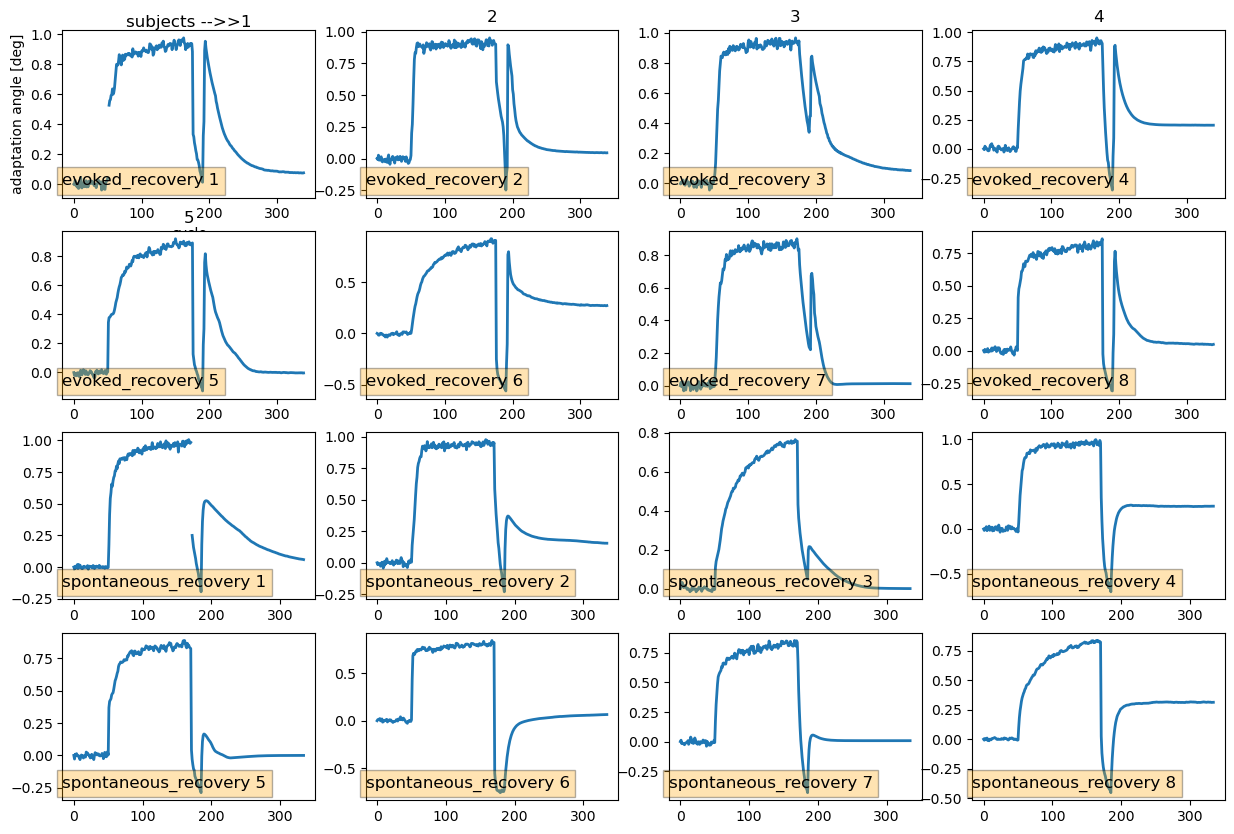

In [13]:
plt.figure(figsize=(15,10))
for k in opt_data:
    if k > 15:
        continue
    plt.subplot(4,4,k+1)
    # ydata_model = outs[k]
    # xdata_model = np.arange(1,len(ydata_model)+1)
    # ydata_experiment = data[k]
    # xdata_experiment = np.arange(1,len(ydata_experiment)+1)
    # #remove nans
    # xdata_model = xdata_model[~np.isnan(ydata_model)]
    # ydata_model = ydata_model[~np.isnan(ydata_model)]
    # xdata_experiment = xdata_experiment[~np.isnan(ydata_experiment)]
    # ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]
    # # output as csv
    # # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_model.csv', np.array([xdata_model,ydata_model]).T, delimiter=',')
    # # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')

    plt.plot(outs[k],linewidth=2)
    if not SKIP_DATA:
        plt.plot(data[k],'.', alpha=0.3)
    if k<5: plt.title(f'{k+1}')
    plt.text(0.0, 0.1, f'{paradigm_by_id_lut[k]} {k%8+1}', 
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(facecolor='orange', alpha=0.3))



plt.subplot(4,4,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')

plt.gca().set_title(f'subjects -->>{1}', pad=-30)



# plt.legend(['model','validation data','fitted data'])    
    
# plt.plot(data[:80,0],'.')
# plt.plot(smooth_signal(data[:,0],3))


In [14]:
A_times = [0,5,10,20,30,100] 
antero_short = {aa: parallel_wrapped_runner([(k,[(0,20),(1,A_time),(-1,40)],opt_data[k][pooling_fun]['x']) for k in opt_data]) for aa,A_time in enumerate(A_times)}
antero_short_preambled = {aa: parallel_wrapped_runner([(k,[(0,150),(1,A_time),(-1,40)],opt_data[k][pooling_fun]['x']) for k in opt_data]) for aa,A_time in enumerate(A_times)}

Simulting the COIN model
Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model

Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model
Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN model



/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/genera

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN modelSimulting the COIN modelSimulting the COIN model
Simulting the COIN modelSimulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])



Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])



Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model




  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])



Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/

Simulting the COIN model


100%|██████████| 10/10 [02:35<00:00, 15.57s/it]


Simulting the COIN model


100%|██████████| 10/10 [02:35<00:00, 15.57s/it]


Simulting the COIN model


100%|██████████| 10/10 [02:44<00:00, 16.42s/it]


Simulting the COIN model


100%|██████████| 10/10 [02:46<00:00, 16.67s/it]


Simulting the COIN model


100%|██████████| 10/10 [02:48<00:00, 16.89s/it]


Simulting the COIN model


 80%|████████  | 8/10 [02:51<00:41, 20.61s/it]]


Simulting the COIN model


100%|██████████| 10/10 [02:50<00:00, 17.06s/it]


Simulting the COIN model


100%|██████████| 10/10 [03:10<00:00, 19.04s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)
100%|██████████| 10/10 [01:41<00:00, 10.20s/it]


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model
Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]


Simulting the COIN modelSimulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]


Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model
Simulting the COIN modelSimulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(c

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model
Simulting the COIN modelSimulting the COIN model

Simulting the COIN model




  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model
Simulting the COIN modelSimulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model



/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: R

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
100%|██████████| 10/10 [03:07<00:00, 18.79s/it]


Simulting the COIN model


100%|██████████| 10/10 [03:34<00:00, 21.45s/it]


Simulting the COIN model


100%|██████████| 10/10 [03:46<00:00, 22.65s/it]


Simulting the COIN model


100%|██████████| 10/10 [03:49<00:00, 22.91s/it]


Simulting the COIN model


 90%|█████████ | 9/10 [03:51<00:25, 25.69s/it]

Simulting the COIN model


100%|██████████| 10/10 [03:51<00:00, 23.16s/it]


Simulting the COIN model


100%|██████████| 10/10 [03:52<00:00, 23.26s/it]


Simulting the COIN model


100%|██████████| 10/10 [03:53<00:00, 23.38s/it]


Simulting the COIN model


100%|██████████| 10/10 [04:05<00:00, 24.55s/it]

100%|██████████| 10/10 [02:01<00:00, 12.16s/it]


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)



Simulting the COIN modelSimulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model



/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weight

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN modelSimulting the COIN model

Simulting the COIN modelSimulting the COIN modelSimulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model
Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilit

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
100%|██████████| 10/10 [03:24<00:00, 2

Simulting the COIN model


100%|██████████| 10/10 [03:47<00:00, 22.74s/it]


Simulting the COIN model


100%|██████████| 10/10 [04:10<00:00, 25.05s/it]


Simulting the COIN model


100%|██████████| 10/10 [04:14<00:00, 25.48s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)


Simulting the COIN model


100%|██████████| 10/10 [04:18<00:00, 25.80s/it]


Simulting the COIN model


100%|██████████| 10/10 [04:19<00:00, 25.96s/it]


Simulting the COIN model


100%|██████████| 10/10 [04:18<00:00, 25.88s/it]


Simulting the COIN model


100%|██████████| 10/10 [04:19<00:00, 25.90s/it]


Simulting the COIN model


100%|██████████| 10/10 [02:12<00:00, 13.21s/it]


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/genera

Simulting the COIN modelSimulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN modelSimulting the COIN model




  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model
Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model

Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]


Simulting the COIN modelSimulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]



Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["pr

Simulting the COIN model


100%|██████████| 10/10 [04:26<00:00, 26.60s/it]


Simulting the COIN model


100%|██████████| 10/10 [04:40<00:00, 28.01s/it]


Simulting the COIN model


100%|██████████| 10/10 [04:43<00:00, 28.38s/it]


Simulting the COIN model


100%|██████████| 10/10 [04:46<00:00, 28.60s/it]


Simulting the COIN model


100%|██████████| 10/10 [04:47<00:00, 28.72s/it]


Simulting the COIN model


100%|██████████| 10/10 [04:50<00:00, 29.06s/it]


Simulting the COIN model


100%|██████████| 10/10 [04:51<00:00, 29.14s/it]


Simulting the COIN model


100%|██████████| 10/10 [04:59<00:00, 29.93s/it]

100%|██████████| 10/10 [05:10<00:00, 31.10s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)
100%|██████████| 10/10 [02:32<00:00, 15.24s/it]


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])



Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN modelSimulting the COIN model




  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/genera

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model
Simulting the COIN modelSimulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)



Simulting the COIN modelSimulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)



Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)



Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]


Simulting the COIN modelSimulting the COIN modelSimulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_st

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342

Simulting the COIN model


100%|██████████| 10/10 [04:54<00:00, 29.42s/it]


Simulting the COIN model


100%|██████████| 10/10 [04:57<00:00, 29.74s/it]


Simulting the COIN model


100%|██████████| 10/10 [04:58<00:00, 29.88s/it]


Simulting the COIN model


100%|██████████| 10/10 [05:11<00:00, 31.14s/it]


Simulting the COIN model


100%|██████████| 10/10 [05:11<00:00, 31.15s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)


Simulting the COIN model


100%|██████████| 10/10 [05:14<00:00, 31.47s/it]


Simulting the COIN model


100%|██████████| 10/10 [05:18<00:00, 31.85s/it]


Simulting the COIN model


100%|██████████| 10/10 [02:44<00:00, 16.40s/it]


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_

Simulting the COIN modelSimulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model
Simulting the COIN model
Simulting the COIN modelSimulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilit

Simulting the COIN model
Simulting the COIN modelSimulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model
Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN modelSimulting the COIN modelSimulting the COIN model





/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c

Simulting the COIN model


100%|██████████| 10/10 [07:40<00:00, 46.08s/it]


Simulting the COIN model


100%|██████████| 10/10 [07:56<00:00, 47.66s/it]


Simulting the COIN model


100%|██████████| 10/10 [08:08<00:00, 48.82s/it]


Simulting the COIN model


100%|██████████| 10/10 [08:11<00:00, 49.13s/it]


Simulting the COIN model


100%|██████████| 10/10 [08:18<00:00, 49.81s/it]


Simulting the COIN model


100%|██████████| 10/10 [08:33<00:00, 51.40s/it]


Simulting the COIN model


100%|██████████| 10/10 [08:44<00:00, 52.46s/it]


Simulting the COIN model


100%|██████████| 10/10 [08:59<00:00, 53.95s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)
100%|██████████| 10/10 [05:18<00:00, 31.87s/it]


Simulting the COIN model
Simulting the COIN model
Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/genera

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)



Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])



Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: 

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)



Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]


Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN modelSimulting the COIN model

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)



Simulting the COIN modelSimulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])




Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_

Simulting the COIN model


100%|██████████| 10/10 [07:06<00:00, 42.63s/it]


Simulting the COIN model


100%|██████████| 10/10 [07:10<00:00, 43.04s/it]


Simulting the COIN model


100%|██████████| 10/10 [07:40<00:00, 46.06s/it]


Simulting the COIN model


100%|██████████| 10/10 [07:50<00:00, 47.05s/it]


Simulting the COIN model


100%|██████████| 10/10 [07:57<00:00, 47.79s/it]


Simulting the COIN model


100%|██████████| 10/10 [07:59<00:00, 47.92s/it]


Simulting the COIN model


100%|██████████| 10/10 [08:03<00:00, 48.38s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)
 80%|████████  | 8/10 [08:03<02:04, 62.40s/it]

Simulting the COIN model


100%|██████████| 10/10 [08:21<00:00, 50.12s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)
100%|██████████| 10/10 [06:11<00:00, 37.15s/it]


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_

Simulting the COIN modelSimulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN modelSimulting the COIN model




/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN modelSimulting the COIN modelSimulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN modelSimulting the COIN modelSimulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_fe

Simulting the COIN model


100%|██████████| 10/10 [08:13<00:00, 49.36s/it]


Simulting the COIN model


100%|██████████| 10/10 [08:21<00:00, 50.13s/it]


Simulting the COIN model


100%|██████████| 10/10 [08:53<00:00, 53.31s/it]


Simulting the COIN model


100%|██████████| 10/10 [08:57<00:00, 53.76s/it]


Simulting the COIN model


100%|██████████| 10/10 [09:12<00:00, 55.24s/it]


Simulting the COIN model


100%|██████████| 10/10 [09:12<00:00, 55.27s/it]


Simulting the COIN model


100%|██████████| 10/10 [09:17<00:00, 55.72s/it]


Simulting the COIN model


100%|██████████| 10/10 [09:41<00:00, 58.12s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)
100%|██████████| 10/10 [07:29<00:00, 44.92s/it]

100%|██████████| 10/10 [06:52<00:00, 41.30s/it]


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]


Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]


Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/genera

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model
Simulting the COIN modelSimulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]


Simulting the COIN modelSimulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]



Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: 

Simulting the COIN model


100%|██████████| 10/10 [08:29<00:00, 50.92s/it]


Simulting the COIN model


100%|██████████| 10/10 [08:37<00:00, 51.80s/it]


Simulting the COIN model


100%|██████████| 10/10 [09:05<00:00, 54.58s/it]


Simulting the COIN model


100%|██████████| 10/10 [09:11<00:00, 55.18s/it]


Simulting the COIN model


100%|██████████| 10/10 [09:23<00:00, 56.38s/it]


Simulting the COIN model


100%|██████████| 10/10 [09:31<00:00, 57.18s/it]


Simulting the COIN model


100%|██████████| 10/10 [09:34<00:00, 57.47s/it]


Simulting the COIN model


100%|██████████| 10/10 [10:33<00:00, 63.39s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)
100%|██████████| 10/10 [07:27<00:00, 44.72s/it]


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN model



/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]


Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

Simulting the COIN modelSimulting the COIN modelSimulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]


Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]




Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model
Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probab

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"

Simulting the COIN model


100%|██████████| 10/10 [08:47<00:00, 52.72s/it]


Simulting the COIN model


100%|██████████| 10/10 [09:18<00:00, 55.89s/it]


Simulting the COIN model


100%|██████████| 10/10 [09:31<00:00, 57.16s/it]


Simulting the COIN model


100%|██████████| 10/10 [09:49<00:00, 58.96s/it]


Simulting the COIN model


100%|██████████| 10/10 [09:54<00:00, 59.46s/it]


Simulting the COIN model


100%|██████████| 10/10 [09:55<00:00, 59.52s/it]


Simulting the COIN model


100%|██████████| 10/10 [10:18<00:00, 61.86s/it]


Simulting the COIN model


100%|██████████| 10/10 [12:45<00:00, 76.58s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)
100%|██████████| 10/10 [07:29<00:00, 44.92s/it]


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])



Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model



/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model
Simulting the COIN model



/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/genera

Simulting the COIN model


100%|██████████| 10/10 [09:31<00:00, 57.11s/it]


Simulting the COIN model


100%|██████████| 10/10 [09:45<00:00, 58.60s/it]


Simulting the COIN model


100%|██████████| 10/10 [10:12<00:00, 61.30s/it]


Simulting the COIN model


100%|██████████| 10/10 [10:27<00:00, 62.71s/it]


Simulting the COIN model


100%|██████████| 10/10 [10:43<00:00, 64.34s/it]


Simulting the COIN model


100%|██████████| 10/10 [10:44<00:00, 64.41s/it]


Simulting the COIN model


100%|██████████| 10/10 [10:47<00:00, 64.72s/it]


Simulting the COIN model


100%|██████████| 10/10 [12:48<00:00, 76.83s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)
100%|██████████| 10/10 [07:34<00:00, 45.48s/it]


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN modelSimulting the COIN modelSimulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]



Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/genera

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN model
Simulting the COIN model
Simulting the COIN model
Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilit

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
 10%|█         | 1/10 [01:39<14:59, 99.92s/it]/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
100%|██████████| 10/10 [12:03<00:00, 72.34s/it]


Simulting the COIN model


100%|██████████| 10/10 [13:29<00:00, 80.99s/it]


Simulting the COIN model


100%|██████████| 10/10 [13:37<00:00, 81.78s/it]


Simulting the COIN model


100%|██████████| 10/10 [13:38<00:00, 81.88s/it]


Simulting the COIN model


100%|██████████| 10/10 [13:47<00:00, 82.75s/it]


Simulting the COIN model


100%|██████████| 10/10 [14:02<00:00, 84.23s/it]


Simulting the COIN model


100%|██████████| 10/10 [14:31<00:00, 87.16s/it]


Simulting the COIN model


100%|██████████| 10/10 [15:21<00:00, 92.17s/it]


Simulting the COIN model


100%|██████████| 10/10 [17:07<00:00, 102.74s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)
100%|██████████| 10/10 [11:10<00:00, 67.09s/it]


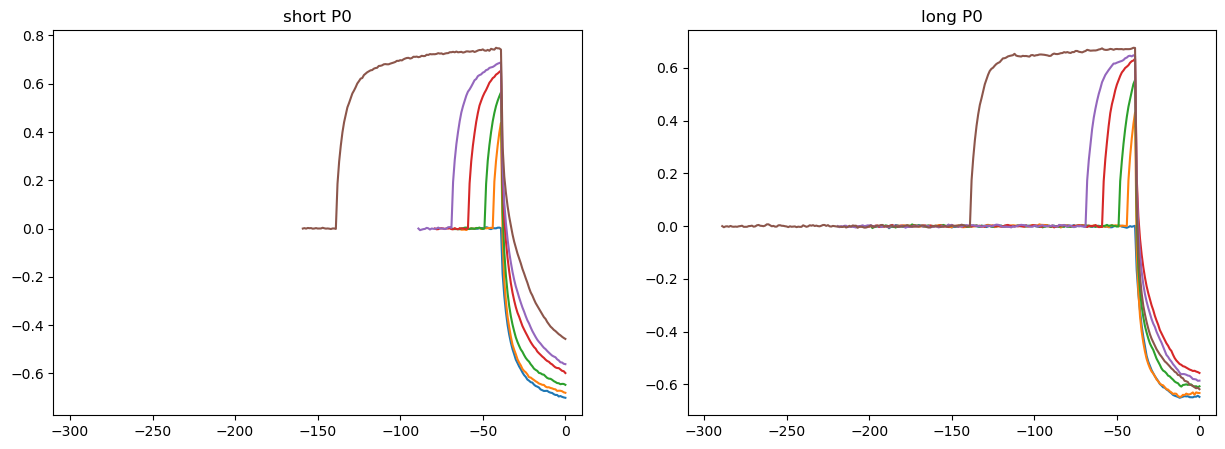

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
for aa,A_time in enumerate(A_times):
    y = np.nanmean(antero_short[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)
    # plt.title(f'average over {len(antero_short[aa])} subjects')
    plt.title(f'short P0')
    plt.xlim([-310,10])

plt.subplot(1,2,2)

for aa,A_time in enumerate(A_times):
    y = np.nanmean(antero_short_preambled[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)
    plt.title(f'long P0')
    plt.xlim([-310,10])


In [ ]:
TaN=150
TaB=120

ref_antero_playlist = {'AB0':[(P0, TaN),(Pminus, TaB)],
'AB1':[(P0, TaN),(Pplus,13),(Pminus, TaB)],
'AB2':[(P0, TaN),(Pplus,41),(Pminus, TaB)],
'AB3':[(P0, TaN),(Pplus,112),(Pminus, TaB)],
'AB4':[(P0, TaN),(Pplus,230),(Pminus, TaB)],
'AB5':[(P0, TaN),(Pplus,410),(Pminus, TaB)]}

# antero   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in ref_antero_playlist.items()}
antero = {aa: parallel_wrapped_runner([(k,aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data]) for aa,aa_item in ref_antero_playlist.items()}
for aa,aa_item in ref_antero_playlist.items():
    y = np.mean(antero[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)
for aa,A_time in enumerate(A_times):
    y = np.mean(antero_short[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)

for aa,aa_item in ref_antero_playlist.items():
    y = np.mean(antero[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model
Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model



/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)



Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)



Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model
Simulting the COIN model
Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]


Simulting the COIN modelSimulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN model

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: 

Simulting the COIN model


100%|██████████| 10/10 [11:09<00:00, 66.97s/it]


Simulting the COIN model


100%|██████████| 10/10 [11:35<00:00, 69.52s/it]


Simulting the COIN model


100%|██████████| 10/10 [11:48<00:00, 70.90s/it]


Simulting the COIN model


100%|██████████| 10/10 [12:31<00:00, 75.20s/it]


Simulting the COIN model


100%|██████████| 10/10 [12:53<00:00, 77.35s/it]


Simulting the COIN model


100%|██████████| 10/10 [13:05<00:00, 78.51s/it]


Simulting the COIN model


100%|██████████| 10/10 [13:40<00:00, 82.05s/it]


Simulting the COIN model


100%|██████████| 10/10 [15:14<00:00, 91.48s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)
100%|██████████| 10/10 [08:34<00:00, 51.46s/it]


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model
Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model
Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]


Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN modelSimulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

Simulting the COIN modelSimulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600:

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model

Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

Simulting the COIN model
Simulting the COIN modelSimulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c

Simulting the COIN model


100%|██████████| 10/10 [14:54<00:00, 89.46s/it]


Simulting the COIN model


100%|██████████| 10/10 [14:59<00:00, 89.92s/it]


Simulting the COIN model


100%|██████████| 10/10 [15:48<00:00, 94.86s/it]


Simulting the COIN model


100%|██████████| 10/10 [15:54<00:00, 95.43s/it]


Simulting the COIN model


100%|██████████| 10/10 [16:08<00:00, 96.88s/it] 


Simulting the COIN model


100%|██████████| 10/10 [16:17<00:00, 97.72s/it]


Simulting the COIN model


100%|██████████| 10/10 [16:23<00:00, 98.38s/it]


Simulting the COIN model


100%|██████████| 10/10 [18:04<00:00, 108.49s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)
100%|██████████| 10/10 [11:13<00:00, 67.34s/it]


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model
Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)



Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/genera

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])



Simulting the COIN modelSimulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])



Simulting the COIN modelSimulting the COIN model

Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encounter

Simulting the COIN modelSimulting the COIN model

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])



Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN modelSimulting the COIN model




/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountere

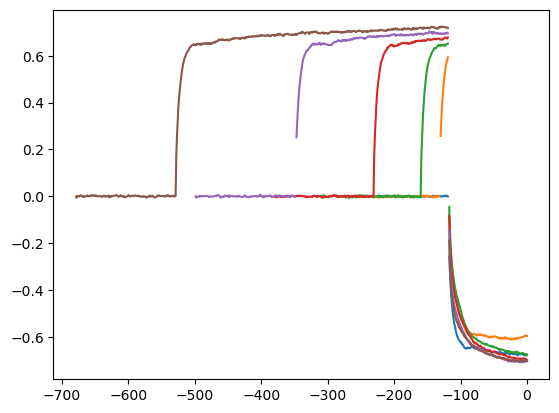

In [20]:
for aa,aa_item in antero.items():
    y = np.mean(antero[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)

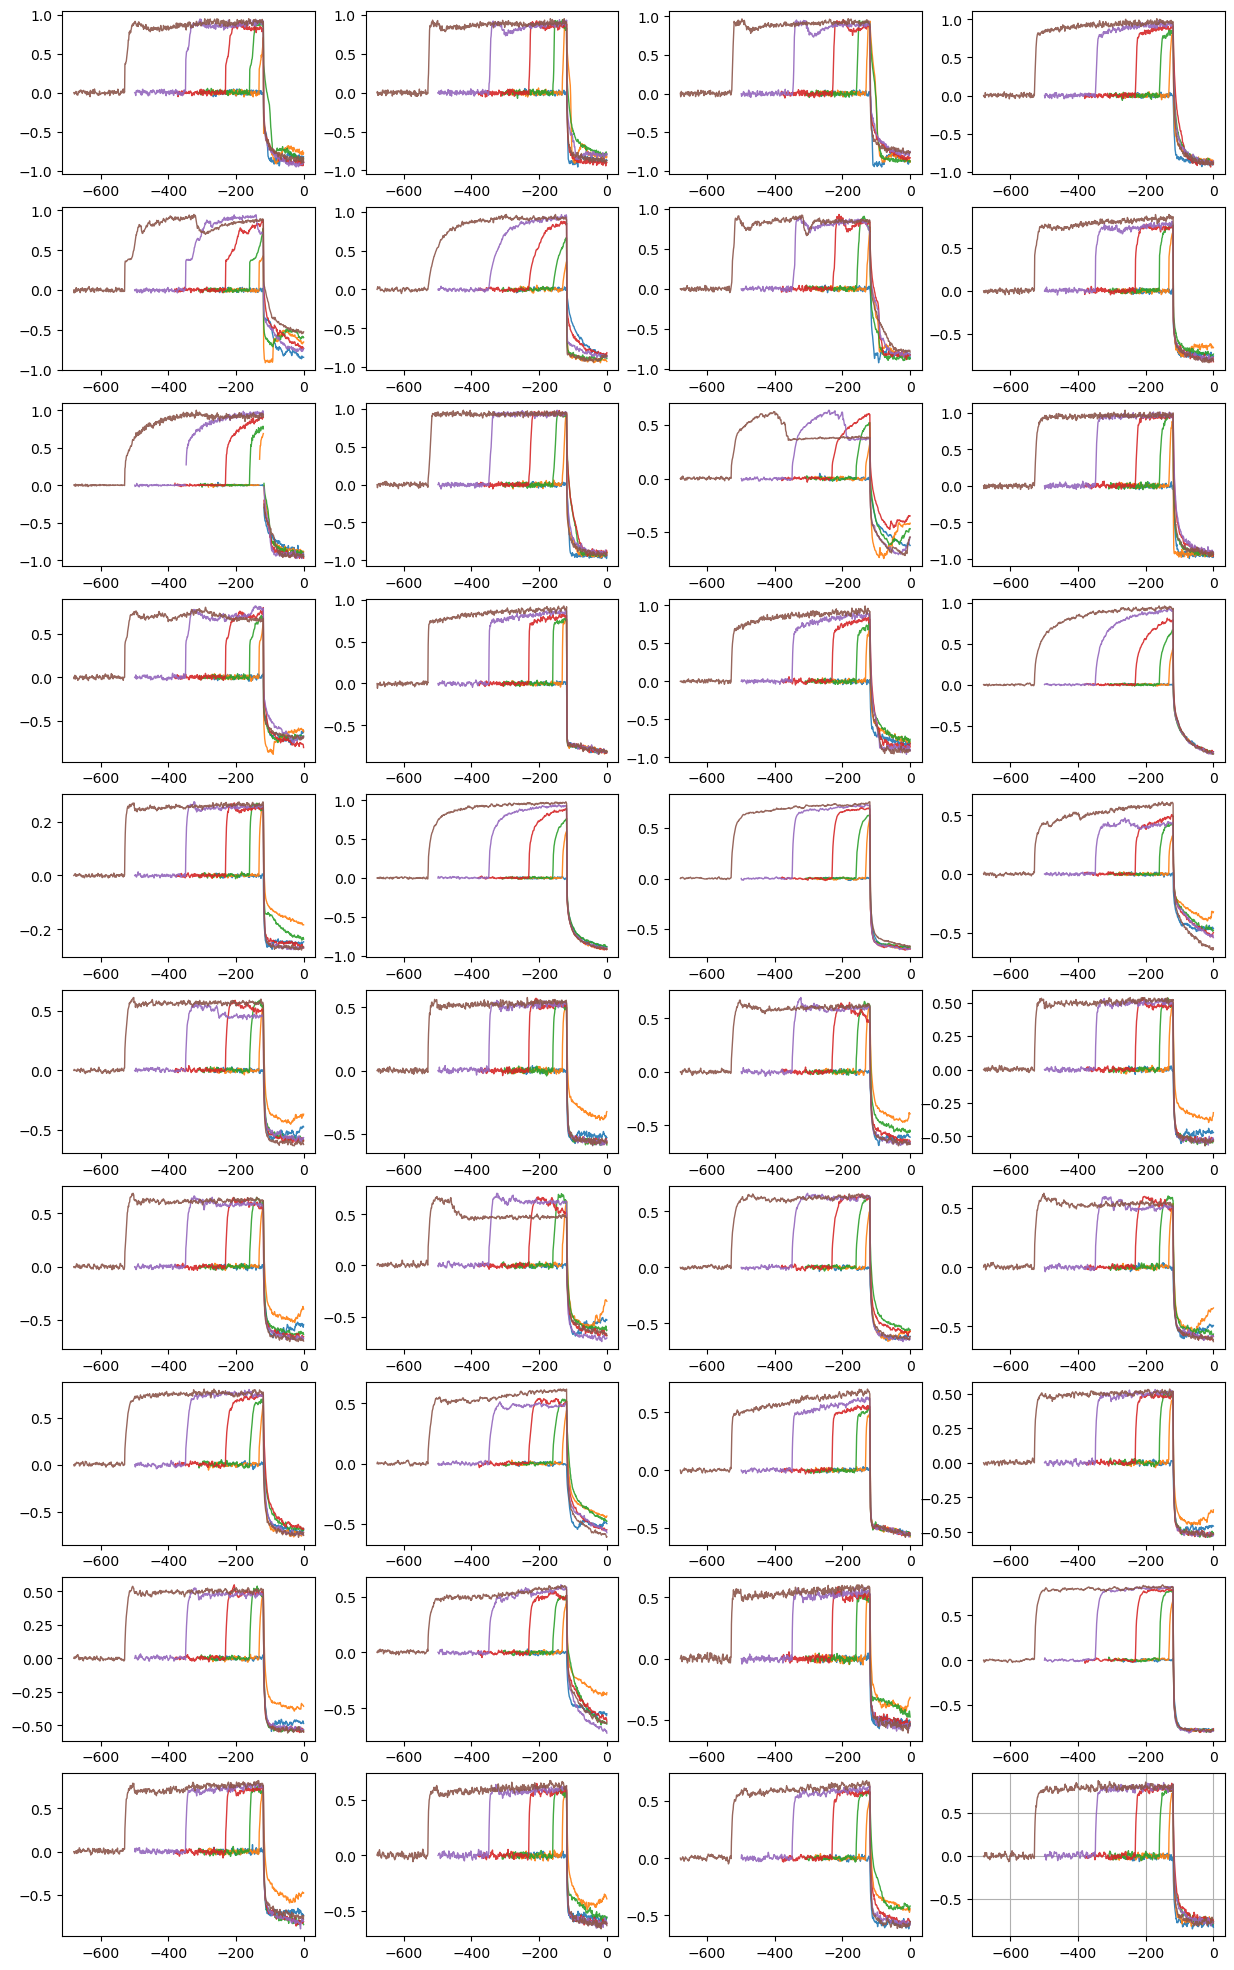

In [21]:
plt.figure(figsize=(15,25))
for ii in range(40):
    for aa,aa_item in antero.items():
        plt.subplot(10,4,ii+1)
        y = antero[aa][ii]
        x = np.arange(len(y))
        x = x - x[-1]
        plt.plot(x,y, linewidth=1, alpha=0.9)
plt.grid()

In [26]:
frog_ens = [True,False]
Tfrog = 400
frogs   = {aa: [ wrapped_runner([(1 if not frog_en else np.linspace(0,1,Tfrog),Tfrog),(0,40)],opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,frog_en in enumerate(frog_ens)}

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
100%|██████████| 1/1 [00:08<00:00,  8.75s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.83s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.72s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.69s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.74s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.66s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:10<00:00, 10.52s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.79s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.59s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.60s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.82s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.58s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.63s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.24s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.70s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.51s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.98s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.36s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.30s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.98s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.90s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.09s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.14s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.00s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:10<00:00, 10.10s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.87s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.10s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.55s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.21s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.23s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.51s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.69s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.38s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.18s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.54s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.57s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.46s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.95s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.64s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.22s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.89s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.77s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.02s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  9.00s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.89s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.84s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.95s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.91s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.67s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.58s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.41s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.32s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.38s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.21s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.53s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.40s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.59s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.34s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.30s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.54s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.61s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.69s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.57s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.54s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.60s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.69s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.61s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.63s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.54s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.49s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.11s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.65s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.64s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.52s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.64s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.34s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.53s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.63s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.66s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.36s/it]


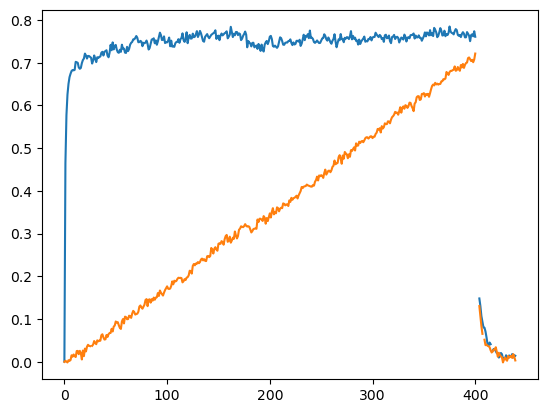

In [27]:
for frog_en in frog_ens:
    plt.plot(np.mean(frogs[frog_en],axis=0))

In [ ]:
from siggen_utils import herzfeld_block


def generate_herzfeld_scenarios(z_list=None, n_blocks=None, Tflips=None): 
    out_dict = {}
    for z in z_list:
        scenario_name =  f'herzfeld,z={z}'
        pert_per_z = []
        for n in range(n_blocks):
            hz = herzfeld_block(z, P1=Pplus,P2=Pminus,P0=P0, tau=1)
            pert_per_z.append((hz,len(hz)))
        out_dict.update({scenario_name:pert_per_z})
    return out_dict

hrz_params = {'z_list': [0.1,0.5,0.9], 'n_blocks': 25}
hrz_playlist =  generate_herzfeld_scenarios(**hrz_params)
her_results   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in hrz_playlist.items()}

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:607: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"])
100%|██████████| 1/1 [00:50<00:00, 50.26s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:74: RuntimeWarning: Mean of empty slice
  state_feedback = np.nanmean([run["state_feedback"] for _,run in runs.items()], axis=0)


Simulting the COIN model


100%|██████████| 1/1 [00:38<00:00, 38.24s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:40<00:00, 40.54s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:37<00:00, 37.52s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:53<00:00, 53.29s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:53<00:00, 53.10s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:43<00:00, 43.97s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:52<00:00, 52.75s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:42<00:00, 42.59s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:39<00:00, 39.83s/it]


Simulting the COIN model


100%|██████████| 1/1 [01:12<00:00, 72.34s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:50<00:00, 50.41s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:53<00:00, 53.07s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:42<00:00, 42.07s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:44<00:00, 44.25s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:50<00:00, 50.83s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:39<00:00, 39.95s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:46<00:00, 46.59s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:47<00:00, 47.36s/it]


Simulting the COIN model


100%|██████████| 1/1 [01:04<00:00, 64.64s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:38<00:00, 38.67s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:38<00:00, 38.94s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:37<00:00, 37.97s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:38<00:00, 38.81s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:38<00:00, 38.22s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:46<00:00, 46.85s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:50<00:00, 50.55s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:55<00:00, 55.85s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:50<00:00, 50.26s/it]


Simulting the COIN model


100%|██████████| 1/1 [01:17<00:00, 77.64s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:38<00:00, 38.62s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:43<00:00, 43.52s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:39<00:00, 39.45s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:39<00:00, 39.79s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:38<00:00, 38.28s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:48<00:00, 48.74s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:49<00:00, 49.63s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:39<00:00, 39.19s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:38<00:00, 38.19s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:46<00:00, 46.66s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:38<00:00, 38.29s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:38<00:00, 38.89s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:48<00:00, 48.03s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:38<00:00, 38.59s/it]


Simulting the COIN model


100%|██████████| 1/1 [01:02<00:00, 62.55s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:52<00:00, 52.75s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:43<00:00, 43.82s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:49<00:00, 49.83s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:41<00:00, 41.10s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:38<00:00, 38.01s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:59<00:00, 59.50s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:48<00:00, 48.75s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:53<00:00, 53.62s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:37<00:00, 37.50s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:36<00:00, 36.91s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:51<00:00, 51.02s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:39<00:00, 39.46s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:48<00:00, 48.82s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:47<00:00, 47.14s/it]


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

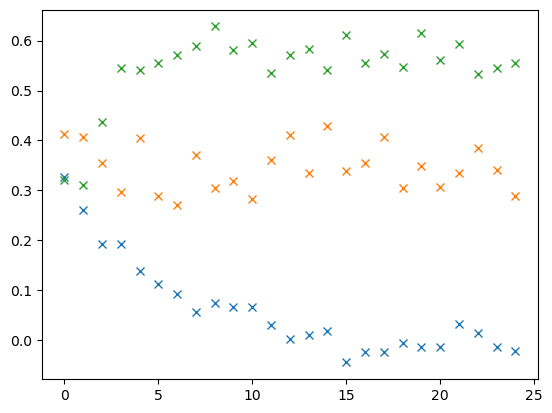

In [ ]:
for iz, z in enumerate(hrz_params['z_list']):
    deltas = []
    mm = lambda x: np.mean(x,axis=0)
    scenario = f'herzfeld,z={z}'
    this_result = her_results[scenario]
    pointer = 0
    for bb in range(hrz_params['n_blocks']):
        block_length = hrz_playlist[scenario][bb][-1]
        pointer += block_length
        deltas.append(mm(her_results[scenario])[pointer-1]-mm(her_results[scenario])[pointer-3])            

    plt.plot(deltas,'x',label = f'z={z}')

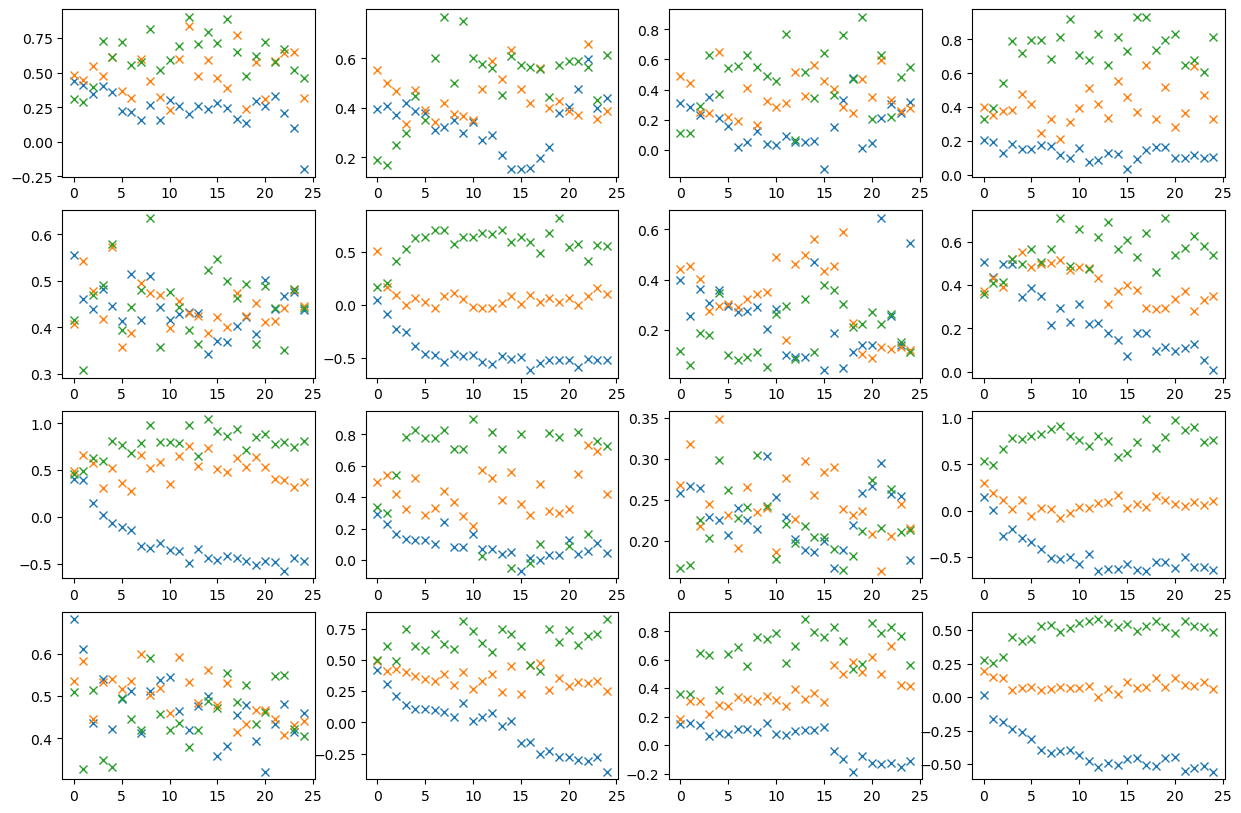

In [ ]:
plt.figure(figsize=(15,10))
for iz, z in enumerate(hrz_params['z_list']):
    for ii in range(16):
        plt.subplot(4,4,ii+1)
        deltas = []
        mm = lambda x: np.mean(x,axis=0)
        scenario = f'herzfeld,z={z}'
        this_result = her_results[scenario]
        pointer = 0
        for bb in range(hrz_params['n_blocks']):
            block_length = hrz_playlist[scenario][bb][-1]
            pointer += block_length
            deltas.append((her_results[scenario])[ii][pointer-1]-(her_results[scenario])[ii][pointer-3])            

        plt.plot(deltas,'x',label = f'z={z}')

In [ ]:
plt.figure(figsize=(15,10))
for iz, z in enumerate(hrz_params['z_list']):
    for ii in range(16):
        plt.subplot(4,4,ii+1)
        deltas = []
        mm = lambda x: np.mean(x,axis=0)
        scenario = f'herzfeld,z={z}'
        this_result = her_results[scenario]
        pointer = 0
        for bb in range(hrz_params['n_blocks']):
            block_length = hrz_playlist[scenario][bb][-1]
            pointer += block_length
            deltas.append((her_results[scenario])[ii][pointer-1]-(her_results[scenario])[ii][pointer-3])            

        plt.plot(deltas,'x',label = f'z={z}')

NameError: name 'plt' is not defined

In [ ]:
np.shape(her_results[scenario][0][pointer-1])

()

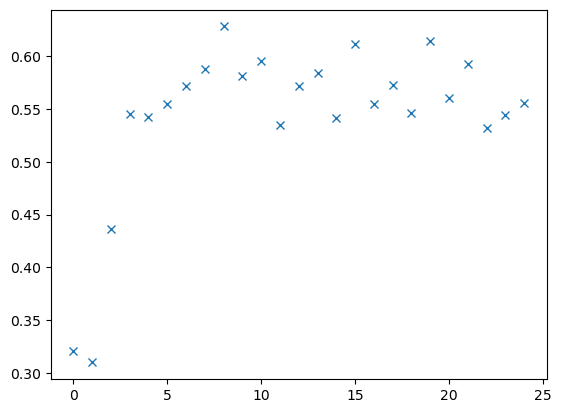

In [ ]:
plt.plot(deltas,'x',label = f'z={z}')

In [ ]:
playlist = {'Ac':[(P0, 200),(Pplus, 200),(Pchannel,200)],
            'ABc':[(P0, 200),(Pplus, 200),(Pminus, 200),(Pchannel,200)]}

results   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in playlist.items()}


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:17<00:00, 17.02s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:15<00:00, 15.93s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:17<00:00, 17.50s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:12<00:00, 12.84s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.77s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:15<00:00, 15.23s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.53s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.68s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:14<00:00, 14.97s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.59s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.47s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:12<00:00, 12.57s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.86s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:12<00:00, 12.28s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:13<00:00, 13.13s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:17<00:00, 17.14s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:29<00:00, 29.80s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:24<00:00, 24.60s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:25<00:00, 25.89s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:22<00:00, 22.73s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:27<00:00, 27.00s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:36<00:00, 36.24s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:25<00:00, 25.76s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:25<00:00, 25.87s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:26<00:00, 26.69s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:21<00:00, 21.54s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:26<00:00, 26.38s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:23<00:00, 23.34s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:25<00:00, 25.63s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:19<00:00, 19.79s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:23<00:00, 23.72s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:25<00:00, 25.17s/it]


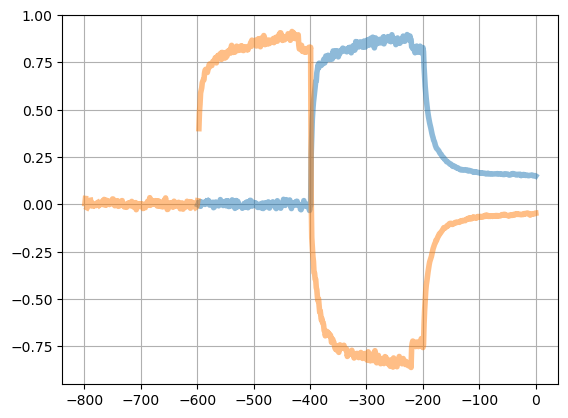

In [ ]:
for aa,aa_item in results.items():
    y = np.mean(results[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y, linewidth=4, alpha=0.5)
plt.grid()

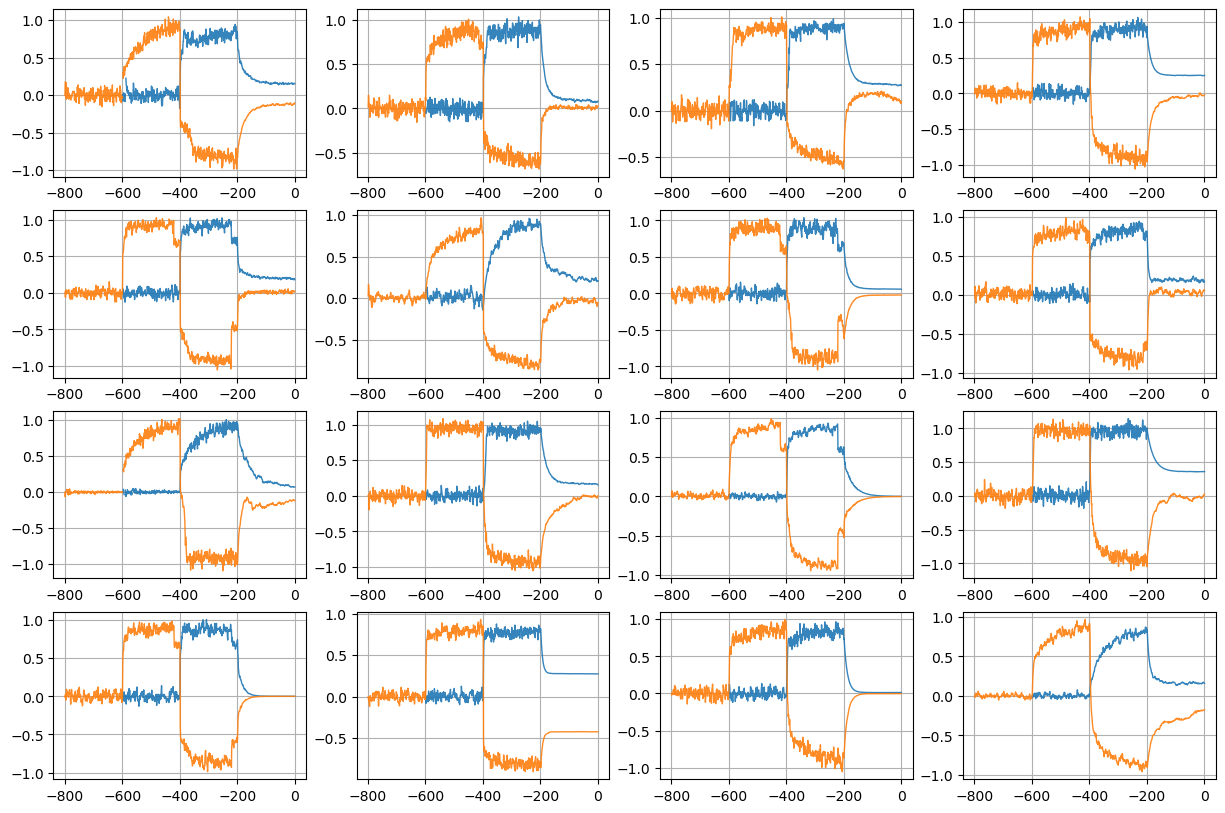

In [ ]:
plt.figure(figsize=(15,10))
for ii in range(16):
    for aa,aa_item in results.items():
        plt.subplot(4,4,ii+1)
        y = results[aa][ii]
        x = np.arange(len(y))
        x = x - x[-1]
        plt.plot(x,y, linewidth=1, alpha=0.9)
    plt.grid()

In [ ]:
for ii in range(16):
    for aa,aa_item in results.items():
        plt.subplot(4,4,ii+1)
        y = results[aa][ii]
        x = np.arange(len(y))
        x = x - x[-1]
        plt.plot(x,y, linewidth=1, alpha=0.9)
plt.grid()

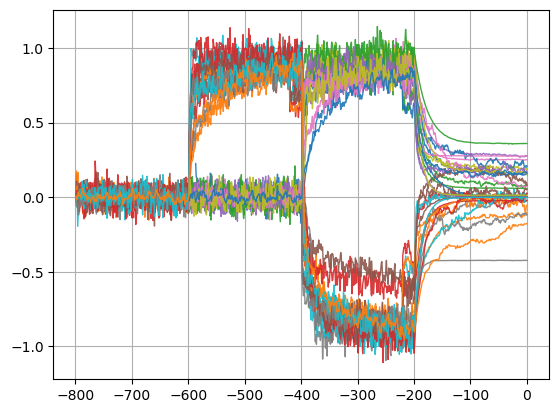

In [ ]:
for ii in range(16):
    for aa,aa_item in results.items():
        # plt.subplot(4,4,ii+1)
        y = results[aa][ii]
        x = np.arange(len(y))
        x = x - x[-1]
        plt.plot(x,y, linewidth=1, alpha=0.9)
plt.grid()